In [4]:
!pip install torchmetrics==0.11.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import Accuracy
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [6]:
# 데이터
trans = transforms.ToTensor()

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=trans)
val_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=trans)

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.97MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.30MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.60MB/s]


In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
# 모델
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10, bias=True)
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [11]:
# metrics
train_acc_metric = Accuracy(task="multiclass", num_classes=10).to(device)
val_acc_metric = Accuracy(task="multiclass", num_classes=10).to(device)

In [12]:
# 학습 루프
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, 11):
    model.train()
    train_loss = 0
    #### 1. reset
    train_acc_metric.reset()  # train_acc metric initialize

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        ### 2. Update
        train_loss += loss.item()
        train_acc_metric.update(output, y) # train_acc metric update

    ### 3. Compute
    train_acc = train_acc_metric.compute().item()  # train_acc metric compute

    model.eval()
    val_loss = 0
    val_acc_metric.reset()

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_acc_metric.update(output, y)

    val_acc = val_acc_metric.compute().item()

    # 저장
    # train_losses.append(train_loss)
    # val_losses.append(val_loss)
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch} | Train Loss: {train_loss/ len(train_loader):.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss/ len(val_loader):.4f} | Val Acc: {val_acc:.4f}")

Epoch 1 | Train Loss: 0.2399 | Train Acc: 0.9303 | Val Loss: 0.1508 | Val Acc: 0.9576
Epoch 2 | Train Loss: 0.1594 | Train Acc: 0.9561 | Val Loss: 0.1828 | Val Acc: 0.9541
Epoch 3 | Train Loss: 0.1416 | Train Acc: 0.9623 | Val Loss: 0.1794 | Val Acc: 0.9583
Epoch 4 | Train Loss: 0.1337 | Train Acc: 0.9643 | Val Loss: 0.1574 | Val Acc: 0.9620
Epoch 5 | Train Loss: 0.1216 | Train Acc: 0.9679 | Val Loss: 0.1981 | Val Acc: 0.9555
Epoch 6 | Train Loss: 0.1209 | Train Acc: 0.9689 | Val Loss: 0.1972 | Val Acc: 0.9651
Epoch 7 | Train Loss: 0.1108 | Train Acc: 0.9723 | Val Loss: 0.2198 | Val Acc: 0.9603
Epoch 8 | Train Loss: 0.1106 | Train Acc: 0.9733 | Val Loss: 0.2051 | Val Acc: 0.9617
Epoch 9 | Train Loss: 0.0990 | Train Acc: 0.9759 | Val Loss: 0.2458 | Val Acc: 0.9665
Epoch 10 | Train Loss: 0.0922 | Train Acc: 0.9783 | Val Loss: 0.2484 | Val Acc: 0.9616


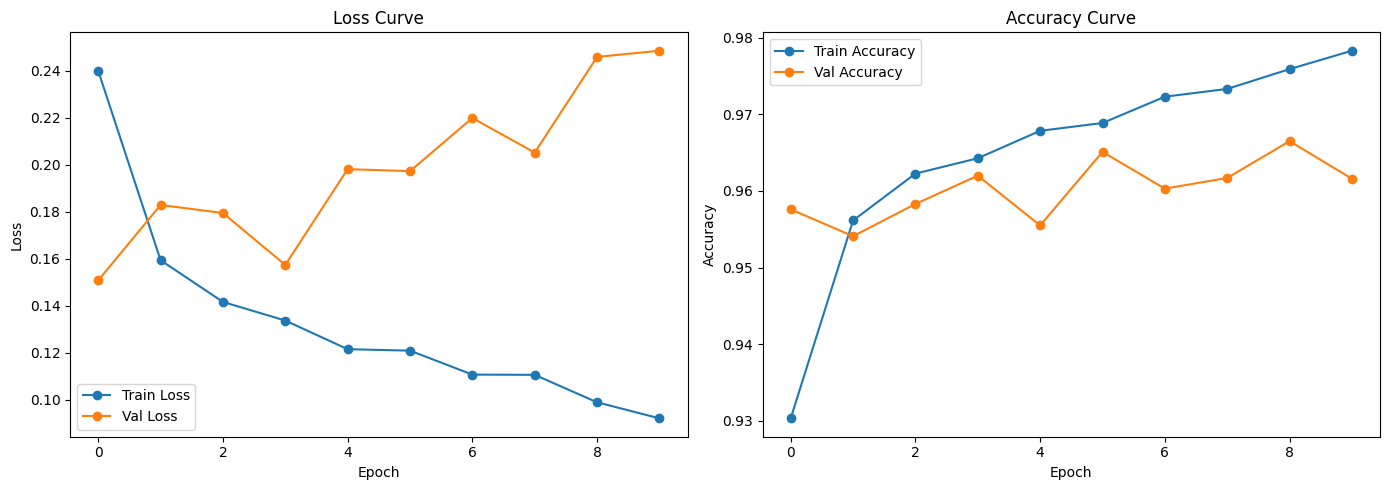

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Val Accuracy', marker='o')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
def evaluate_classification_metrics(model, dataloader, device, num_classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # 계산
    # macro : 모든 클래스에 대해 동등한 중요도를 두고 평가 (클래스 불균형에 민감하지 않음)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)

    # 출력
    print("Precision (macro): {:.4f}".format(precision))
    print("Recall (macro): {:.4f}".format(recall))
    print("F1-score (macro): {:.4f}".format(f1))
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, digits=4))

    # Confusion Matrix 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(num_classes),
                yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


Precision (macro): 0.9614
Recall (macro): 0.9607
F1-score (macro): 0.9609

Classification Report:

              precision    recall  f1-score   support

           0     0.9717    0.9816    0.9766       980
           1     0.9868    0.9859    0.9863      1135
           2     0.9559    0.9874    0.9714      1032
           3     0.9542    0.9693    0.9617      1010
           4     0.9610    0.9532    0.9571       982
           5     0.9404    0.9372    0.9388       892
           6     0.9898    0.9113    0.9489       958
           7     0.9679    0.9689    0.9684      1028
           8     0.9406    0.9600    0.9502       974
           9     0.9459    0.9524    0.9491      1009

    accuracy                         0.9616     10000
   macro avg     0.9614    0.9607    0.9609     10000
weighted avg     0.9619    0.9616    0.9615     10000



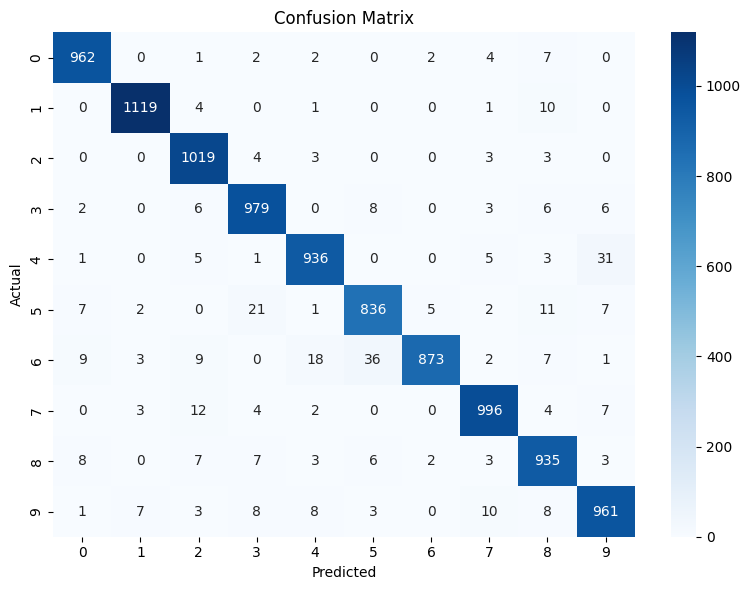

In [18]:
evaluate_classification_metrics(model, val_loader, device, num_classes=10)